# Analysis of Poly A/U RNA tails from RNA-Seq data

The notebook contains the workflow of analysis of Poly A tails of mRNA. It's directed for the genome of fission yeast (*Schizosaccharomyces pombe*) - RNA-Seq data.
The **main aim** is the detection and analysis of 3' tails of mRNA.


### Input:
    data in bam format from RNA-Seq (data from HiSeq)


### Steps:
    1. Extract unmapped reads from bam files.
    2. Convert the bam file into fastq.
    3. Merge all of the technical/biological repetition - merge fastq files.    
    4. Extract only the reads containing at least 6 A or U an 3' tail of RNA.    
    5. Remove the polyA/U tails from the 3' tail of RNA, and move the tails to the header.
    6. Do mapping using HiSat2.   
    7. Convert mapped reads (the sam file) into bam, bed.   
    8. Make bw file from bam.  
    9. Use deeptools to visualize the results: computeMatrix and plotProfile.
    10. Use bedtools closest to find the genes where the reads were mapped.
    11. Make the analysis of lenght of extracted tails.

## Prepare the data and file with annotations (references)

1. Save the raw data (in fasta/ fastq/ bam) in file 'data'. 
    We will use data in format .bam, but you can convert the format to bam.

2. Prepere references with annotation in file 'reference'

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Extract unmapped reads from bam files


The examples of code for each sample

> samtools view -b -f 4 data/input.bam > processing_data/output_unmapped.bam

In [ ]:
# An example

!samtools view -b -f 4 data/unmapped/C1_1.bam > processing_data/C1_1_unmapped.bam

**Jupyter notebook tricks and hacks**:

you can run a bash command in Jupyter notebook by:
1. using the exclamation mark (!) just before the command
> !head mytext.txt
2. using "%%bash" command at the beginning of the cell
> %%bash
>
> head mytext.txt

## 2. Convert the bam file into fastq
> bedtools bamtofastq -i processing_data/output_unmapped.bam -fq processing_data/output_unmapped.fastq
    
I recommend to do it one by one and check if everything looks good using 'head' function in console:

> head processing_data/output_unmapped.fastq

In [ ]:
# An example
!bedtools bamtofastq -i processing_data/C1_1_unmapped.bam -fq processing_data/C1_1_unmapped.fastq

In [ ]:
# Check the first reads of the fastq file
!head processing_data/C1_1_unmapped.fastq

# 3. Merge all of technical/ biological repetition - merge fastq files
It is a high time to merge the technical and biological repetitions. We will merge two biological repetitions

> C1_2_unmapped.fastq + C1_2_unmapped.fastq >> C1_merged_unmapped.fastq.fastq

using cat function:
> cat processing_data/output_*_unmapped.fastq > data/unmapped/merged_C1.fastq
   

In [ ]:
# The examples of code for each merged file

!cat processing_data/C1_*_unmapped.fastq > data/unmapped/merged_C1.fastq

In [ ]:
# Check the first reads of the fastq file
!head data/unmapped/merged_C1.fastq

## Important substep:##
>
>    please open your fastq file and check several sequences using Blast - find the alignment of some the reads with genome of S. pombe. In this step you will check the 'conformation' of your reads. 
>
>    If you will find the alignment with the genome of S. pombe, just follow the script.
>
>    If not - try to transcribe the sequences of the reads and if after that the sequence fing alignment, change the script taking into account that for example you will analyse only reads R2 -> in this sitaution you will look for the tails at the beginning of the reads:
>
>                                  polyA tails:  5'-................AAAAAAAAAA-3'
>               polyA tails in our fastq files:  3'-TTTTTTTTTT................-5'

## 4. Extract only the reads containing at least 6 A or U an 3' tail of RNA
We want to extract only the reads potentially containing polyA/U tails. We will extract these reads with grep with proper options.
After the grep, we will remove the polyA/U tails, and will do mapping of reads without tails.

#### We will find which reads will be mapping to the annotations after removing reads. 

#### Example:
>grep [options] [tails] input.fastq >> output.fastq
>
>grep -A 2 -B 1 "[AT][AT][AT][AT][AT][AT]$" unmapped_reads_merged.fastq >> unmapped_grepped.fastq

**Options** :

- -A num, --after-context=num  -->  -A 2 It takes two rows after the grepped squence
- -B num, --before-context=num -->  -B 1 It takes one row before the grepped squence

More options: https://en.wikibooks.org/wiki/Grep

In [ ]:
# The examples of code for each merged file

!grep -A 2 -B 1 "[AT][AT][AT][AT][AT][AT]$" data/unmapped/merged_C1.fastq > data/unmapped/merged_C1_unmapgrep.fastq


## Neccessary step:
The merged fastq file can contain the additional unusful lines with '--'. You can open the merged file in geany (or another text editor) and remove the additional lines with regular expression:
#### Regex:
>    Find: \-\-\n 
>
>    Replace:      (nothing)
>
>    Save the changes.

## 5. Remove the 3' poly A/U tails of RNA and move their sequence to geader of the read

Remove 3' RNA poly A/U tails - in this step we will remove sequences poly A/U, and after that we will map the reads again. We will analyze the reads which could not map in case of containing poly A/U tail.

**Below script take each read in the fastq file and move the tails to header. If there is no header, the read name will gain the information "_without tail".**

### This script will grep the tails containing only poli-A sequences

In [ ]:
from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("data/unmapped/out_merged_WT_unmapgrep_poliA.fastq", "w")

infile = SeqIO.parse("data/unmapped/merged_WT_unmapgrep.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    pattern = re.compile("A+AAAA$")
    ogon = re.search(pattern, str(sequence))
    if ogon == None:
        ogon = "withouttail"
    else:
        ogon = ogon.group(0)
        ogon_length = len(ogon)
        sequence = str(sequence[0:(0-ogon_length)])
        seq_length = len(sequence)
        
        quality = str(quality[0:(0-ogon_length)])
    header=str(read.id) + "_" + ogon 
   
    read = fastq
   
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'
    print(new_read)    
    outfile.write(new_read)
   
outfile.close()

### This script will grep the tails containing only poli-U sequences

In [ ]:
from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("data/unmapped/out_merged_WT_unmapgrep_poliU.fastq", "w")

infile = SeqIO.parse("data/unmapped/merged_WT_unmapgrep.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    pattern = re.compile("A+AAAT+$")
    ogon = re.search(pattern, str(sequence))
    if ogon == None:
        ogon = "withouttail"
    else:
        ogon = ogon.group(0)
        ogon_length = len(ogon)
        sequence = str(sequence[0:(0-ogon_length)])
        seq_length = len(sequence)
        
        quality = str(quality[0:(0-ogon_length)])
    header=str(read.id) + "_" + ogon 
   
    read = fastq
   
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'
    print(new_read)    
    outfile.write(new_read)
   
outfile.close()

### This script will grep the tails containing all tails (poli-A, poli_U, poli_AU)

In [ ]:
# This script will grep the tails containing all tails (poli-A, poli_U, poli_AU)

from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("data/unmapped/out_merged_WT_unmapgrep_poliU.fastq", "w")

infile = SeqIO.parse("data/unmapped/merged_WT_unmapgrep.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    pattern = re.compile("A+AAAT+$")
    ogon = re.search(pattern, str(sequence))
    if ogon == None:
        ogon = "withouttail"
    else:
        ogon = ogon.group(0)
        ogon_length = len(ogon)
        sequence = str(sequence[0:(0-ogon_length)])
        seq_length = len(sequence)
        
        quality = str(quality[0:(0-ogon_length)])
    header=str(read.id) + "_" + ogon 
   
    read = fastq
   
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'
    print(new_read)    
    outfile.write(new_read)
   
outfile.close()

## 6. Mapping of cutadapted reads using HiSat2
We removed the polyA/U tails. At this step, we want to mapped the reads (after removing the tails) to references. 

### Mapping with HiSat2:

> hisat2 -q -x [references] [input.fastq] --rna-strandness FR -S [summary_file] --summary-file [summary_file.txt] --new-summary -p 16



In [ ]:
#n example:

!hisat2 -q -x reference/reference processing_data/merged_C1_12_cutadapted.fastq --rna-strandness FR -S summary_file/merged_C1_grepcutmap.sam --summary-file summary_file/merged_C1_grepcutmap.txt --new-summary -p 16

## 7. Convert mapped reads (new sam file) into bam, bed.
#### Convert .sam file (result of the mapping) into  .bam format, and sort it using *SAMTOOLS*
> samtools sort input.sam > input_sorted.bam


In [ ]:
# An axample:
!samtools sort summary_file/nowepliki_merged_WT_grepcutmap_poliAU.bam > summary_file/nowepliki_merged_WT_grepcutmap_poliAU.bam

### Add index to bam (.bam >> .bam.bai)
> samtools index input_sorted.bam

In [ ]:
# An example
!samtools index summary_file/nowepliki_merged_WT_grepcutmap_poliU.bam

#### Convert .sam file (result of the mapping) into .bed file using *BEDOPS*
> sam2bed < input.sam > output.bed

In [ ]:
# An example
!sam2bed < summary_file/merged_WT_grepcutmap.sam > summary_file/merged_WT_grepcutmap.bed

#### BONUS: Convert .sam to fastq

> cat samplename.nomapping.sam | grep -v ^@ | awk 'NR%2==1 {print "@"$1"\n"$10"\n+\n"$11}' > unmapped/samplename_1.fastq 

In [ ]:
!cat summary_file/nowepliki_merged_C1_grepcutmap_poliAU.sam | grep -v ^@ | awk 'NR%2==1 {print "@" 1"\n" 10"\n+\n"$11}' > nowepliki_merged_C1_grepcutmap_poliAU.fastq

## 8. Make bw file from bam using *deepTools*
> bamCoverage -b input.bam -o output.bw


In [ ]:
!bamCoverage -b summary_file/nowepliki_merged_WT_grepcutmap_poliA.bam -o summary_file/nowepliki_WT_poliA.bw

## 9. Use *deepTools* to visualize the results: *computeMatrix* and *plotProfile*.

#### computeMatrix
> computeMatrix scale-regions -S input.bw -R referencje.bed --beforeRegionStartLength 3000 --regionBodyLength 5000 --afterRegionStartLength 3000 --skipZeros -o matrix.mat.gz

In [ ]:
# An example
!computeMatrix scale-regions -S summary_file/nowepliki_WT_*.bw -R reference/newSP_tylkogeny_bezncRNA.bed --beforeRegionStartLength 3000 --regionBodyLength 5000 --afterRegionStartLength 3000 --skipZeros -o summary_file/nowepliki_WT_merged.mat.gz

#### plotProfile
> plotProfile -mmatrix.mat.gz -out plots/output_plot.png --perGroup

In [ ]:
# An example
!plotProfile -m summary_file/nowepliki_WT_merged.mat.gz -out plots/nowepliki_WT_merged.mat.gz.png --perGroup

#### Look at the plots

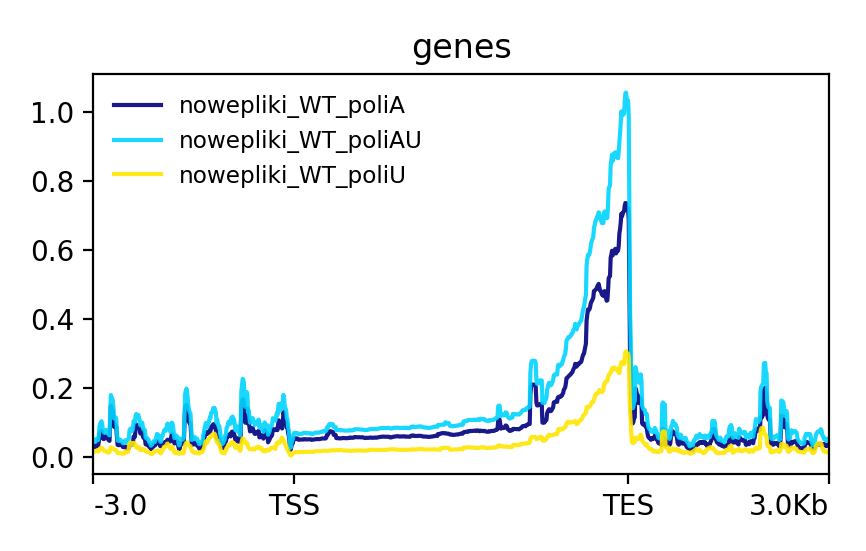

In [3]:
from IPython.display import Image
Image(filename='plots/nowepliki_WT_merged.mat.gz.png')

## Visualization in IGV (Integrative Genomics Viewer)

*'The Integrative Genomics Viewer (IGV) is a high-performance visualization tool for interactive exploration of large, integrated genomic datasets. It supports a wide variety of data types, including array-based and next-generation sequence data, and genomic annotations.'* (http://software.broadinstitute.org/software/igv/)

We created the environmet for IGV in case of possible conflict with other tools (instruction in Readme).

# 11. Use bedtools closest to find the genes where the reads were mapped
> bedtools closest [OPTIONS] -a <FILE> -b <FILE1, FILE2, ..., FILEN>
    
**Input:**
- references in the format .bed6
- file with the reads (containint tails in header) in the format .bed6

**Output:**
- the file in format similar to two merged bed files. It contains in each row at first six columns the coordinates, name of the read, and standedness. After that, the following columns present the same information about the gene which was parsed with proper read.

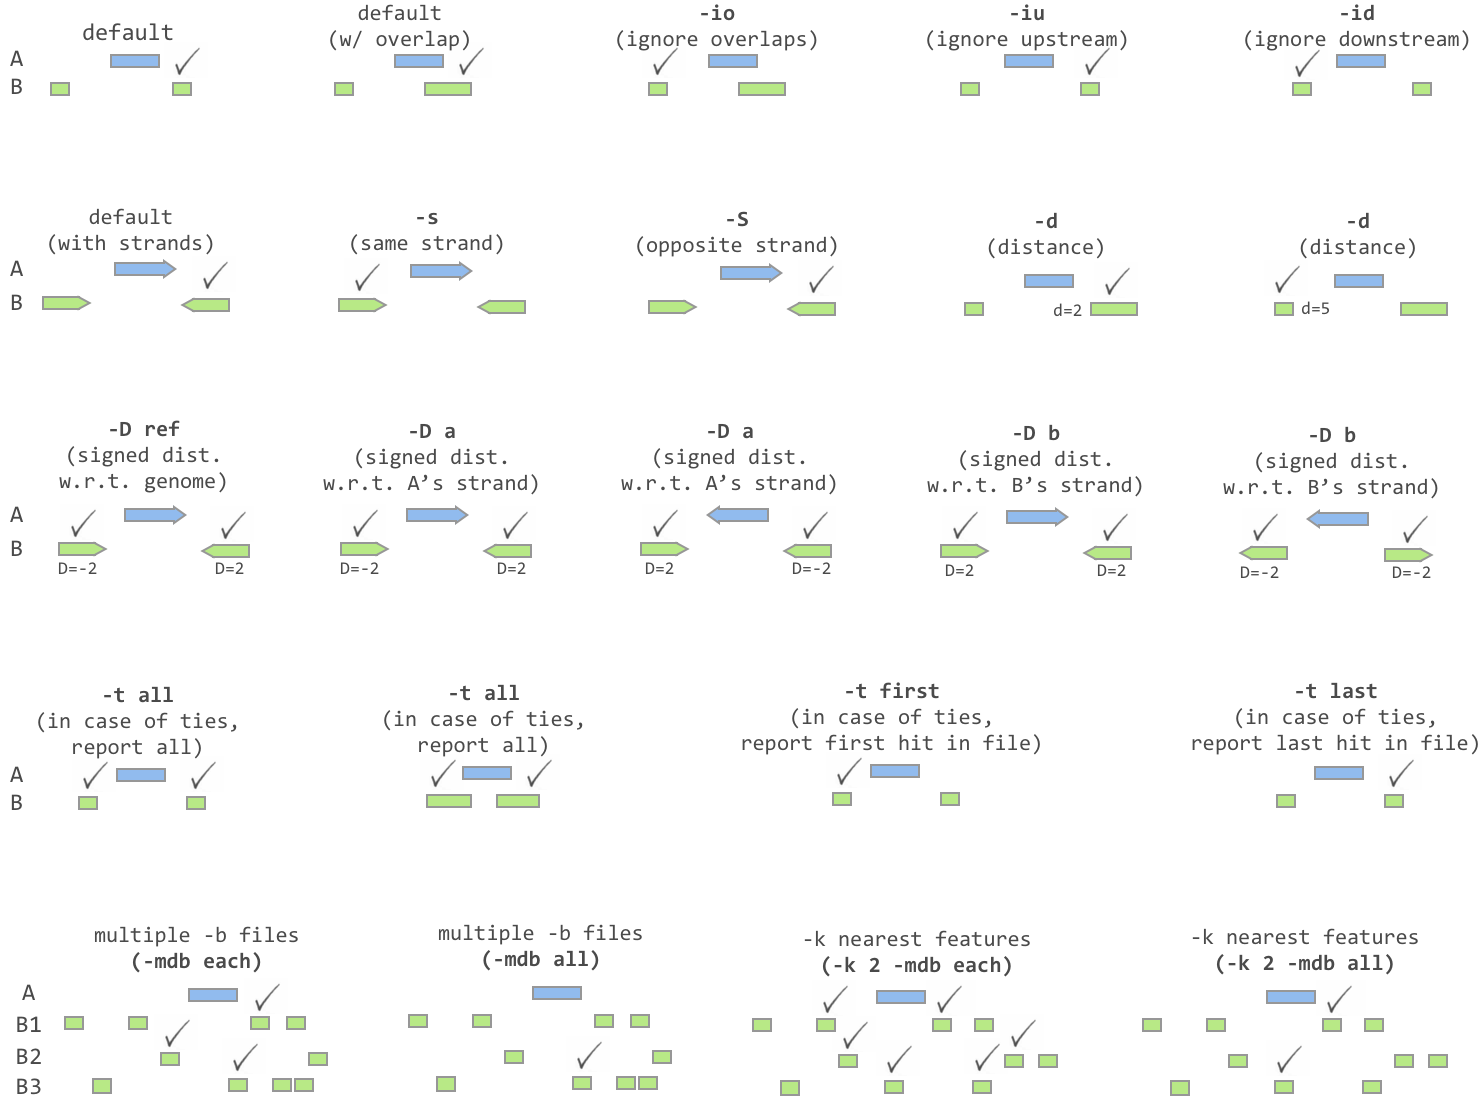

In [5]:
from IPython.display import Image
Image("closest-glyph.png")

#source https://bedtools.readthedocs.io/en/latest/content/tools/closest.html

*Similar to intersect, closest searches for overlapping features in A and B. In the event that no feature in B overlaps the current feature in A, closest will report the nearest (that is, least genomic distance from the start or end of A) feature in B. For example, one might want to find which is the closest gene to a significant GWAS polymorphism. Note that closest will report an overlapping feature as the closest—that is, it does not restrict to closest non-overlapping feature. The following iconic “cheatsheet” summarizes the functionality available through the various options provided by the closest tool. (source https://bedtools.readthedocs.io/en/latest/content/tools/closest.html)*

In [ ]:
!bedtools closest -s -id -a processing_data/sekwencje_cid1_bed6.bed -b processing_data/adnotacje_bed6.bed -D ref > processing_data/closets_C1_id_s.bed

## Analysis of the results after bedtools closest

In [6]:
column_temporary_names = ['a','b','c','d',
                          'e','f','g','h',
                          'i','j','k','l',
                          'm','n','o','p','r']

In [9]:
closets_wt = pd.read_csv('processing_data/closets_WT_id_s.bed', sep = '\t')
closets_wt_ogony_przedclosest = closets_wt
closets_wt_ogony_przedclosest.columns = column_temporary_names[0:13]
closets_wt_ogony_przedclosest = closets_wt_ogony_przedclosest[closets_wt_ogony_przedclosest['a']  != "MT"]
closets_wt_ogony_przedclosest = closets_wt_ogony_przedclosest[closets_wt_ogony_przedclosest['a']  != "MTR"]
closets_wt_ogony_przedclosest = closets_wt_ogony_przedclosest[closets_wt_ogony_przedclosest['a']  != "AB325691"]
ogonki = closets_wt_ogony_przedclosest['d']
tails = ogonki.apply(lambda row: row.split('_')[1])
nazwa_readu = ogonki.apply(lambda row: row.split('_')[0])
tail_leght = tails.str.len()
closets_wt_ogony_przedclosest['tail'] = tails
closets_wt_ogony_przedclosest['tail_leght'] = tail_leght
closets_wt_ogony_przedclosest['read_name'] = nazwa_readu
closets_wt_ogony_przedclosest

,a,b,c,d,e,f,g,h,i,j,k,l,m,tail,tail_leght,read_name
0,I,5569,5624,PC6-231:36:C6KL5ANXX:6:2102:15421:67143_TTTTTT...,0,+,.,-1,-1,.,-1,.,-1,TTTTTTTTTTTT,12,PC6-231:36:C6KL5ANXX:6:2102:15421:67143
1,I,45831,45874,PC6-231:36:C6KL5ANXX:6:1110:16434:29974_TTTTTT...,1,+,I,44643,45468,SPAC977.08,.,+,-364,TTTTTTTTTTTTTT,14,PC6-231:36:C6KL5ANXX:6:1110:16434:29974
2,I,57104,57160,PC6-231:36:C6KL5ANXX:6:1315:16032:33229_TTTTTTTT,0,+,I,56372,57736,SPAC977.12,.,+,0,TTTTTTTT,8,PC6-231:36:C6KL5ANXX:6:1315:16032:33229
3,I,57725,57768,PC6-231:36:C6KL5ANXX:6:2212:10470:65937_TTTTTT...,60,-,I,45874,48399,SPAC977.09c,.,-,-9327,TTTTTTTTTTTT,12,PC6-231:36:C6KL5ANXX:6:2212:10470:65937
4,I,57730,57767,PC6-231:36:C6KL5ANXX:6:1101:7037:52320_TTTTTTTTT,60,-,I,45874,48399,SPAC977.09c,.,-,-9332,TTTTTTTTT,9,PC6-231:36:C6KL5ANXX:6:1101:7037:52320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16292,III,2452337,2452354,PC6-231:36:C6KL5ANXX:6:2208:20251:79147_TTTATT,1,-,III,2429986,2431575,SPCC569.03,.,-,-20763,TTTATT,6,PC6-231:36:C6KL5ANXX:6:2208:20251:79147
16293,III,2452338,2452354,PC6-231:36:C6KL5ANXX:6:2214:12742:4209_TTTATT,1,-,III,2429986,2431575,SPCC569.03,.,-,-20764,TTTATT,6,PC6-231:36:C6KL5ANXX:6:2214:12742:4209
16294,III,2452338,2452407,PC6-231:36:C6KL5ANXX:6:2102:6144:33699_TAAAT,0,-,III,2429986,2431575,SPCC569.03,.,-,-20764,TAAAT,5,PC6-231:36:C6KL5ANXX:6:2102:6144:33699
16295,III,2452692,2452743,PC6-231:36:C6KL5ANXX:6:1303:7280:78031_TATATT,0,+,III,2451882,2452883,SPRRNA.45,.,+,0,TATATT,6,PC6-231:36:C6KL5ANXX:6:1303:7280:78031


Text(0.5, 0, 'Poly AU tail length')

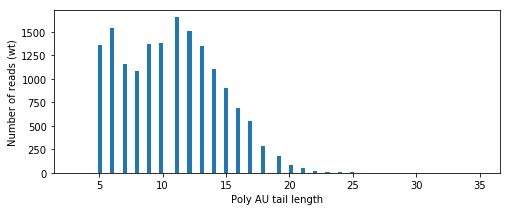

In [12]:
# Make a plot
x = closets_wt_ogony_przedclosest['tail_leght']
plt.figure(figsize=(8,3))
plt.hist(x, bins=100, range=[3, 35])
plt.ylabel('Number of reads (wt)')
plt.xlabel('Poly AU tail length')

### Check the genes which are with the most reads

In [14]:
genes_reads_wt = closets_wt_ogony_przedclosest['j'].value_counts()
genes_reads_wt

SPCC162.03       805
SPAC17A5.02c     706
.                616
SPBC29A3.13      595
SPBC32F12.08c    370
                ... 
SPATRNALYS.02      1
SPAC29A4.03c       1
SPAC1B9.03c        1
SPAC19B12.10       1
SPAC1D4.09c        1
Name: j, Length: 2457, dtype: int64

In [15]:
unique_genes = closets_wt_ogony_przedclosest['j'].unique()
unique_genes

array(['.', 'SPAC977.08', 'SPAC977.12', ..., 'SPRRNA.46', 'SPRRNA.49',
       'SPRRNA.45'], dtype=object)